In [1]:
#@title Import necessary packages and set correct device

import os

import numpy as np
import torch
from tqdm import tqdm

from modules.yoloclip import YoloClip
from modules.refcocog import RefCOCOg, RefCOCOgSample

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("[INFO] GPU found, using GPU.")
else:
    device = torch.device("cpu")
    print("[INFO] No GPU found, using CPU instead.")


[INFO] No GPU found, using CPU instead.


In [2]:
#@title Import RefCOCOg dataset and its train/val/test splits

dataset = RefCOCOg(ds_path='../dataset/refcocog')

train_ds = RefCOCOg(ds_path='../dataset/refcocog', split='train')
val_ds = RefCOCOg(ds_path='../dataset/refcocog', split='val')
test_ds = RefCOCOg(ds_path='../dataset/refcocog', split='test')

print(f"Dataset Size: {len(dataset)}\n")
print(f"Train size: {len(train_ds)}")
print(f"Val size:   {len(val_ds)}")
print(f"Test size:  {len(test_ds)}")


Dataset Size: 49822

Train size: 42226
Val size:   2573
Test size:  5023


In [3]:
#@title Initialize YoloClip pipeline

yoloclip = YoloClip(device=device, quiet=False, dist_metric="cosine", categories=dataset.categories)


Using cache found in /Users/azel/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-3-27 Python-3.9.6 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


[INFO] Running YOLO on the image...
[INFO] YOLO found 6 objects
[INFO] Running CLIP on detected objects...
[INFO] Running CLIP on the prompt...
[INFO] true: sandwich | predicted: person


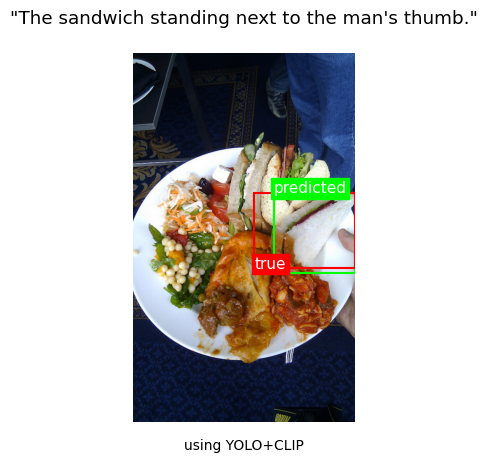

In [4]:
#@tile Test YoloClip on a random sample

%matplotlib inline

idx = np.random.randint(0, len(dataset))

sample = RefCOCOgSample(**dataset[idx])

for sentence in sample.sentences:
    yoloclip(sample, sentence, show=True)


---

In [5]:
#@title Function definition to test visual grounding with a given pipeline

def visual_grounding_test(vg_pipeline, dataset):
    scores = list()

    for sample in tqdm(dataset, desc=f"Testing on {len(dataset)} images"):

        sample = RefCOCOgSample(**sample)

        for sentence in sample.sentences:

            try:
                sc = vg_pipeline(sample, sentence, show=False)
            except ValueError:
                continue

            scores.append(sc)

    for metric in scores[0].keys():
        avg_metric = np.mean([score[metric] for score in scores])

        print("Avg. {}: {:.3f}".format(metric, avg_metric))


In [6]:
#@title Test YoloClip on the test set

yoloclip.quiet = True

visual_grounding_test(yoloclip, test_ds)


Testing on 5023 images: 100%|██████████| 5023/5023 [1:10:58<00:00,  1.18it/s]

Avg. cosine: 0.236
Avg. euclidean: 1.236
Avg. dotproduct: 5.201
Avg. iou: 0.525
Avg. recall: 0.364
